# 16. Analizando el modelo ganador

### Algunas cosas para leer

#### ¿Qué son los valores de Shap?
https://www.modeldifferently.com/2023/02/que-es-shap-explicabilidad-de-modelos-shap/

## Importamos paquetes necesarios

In [60]:
import pandas as pd
import numpy as np
import pydotplus

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

from skopt import gp_minimize
from skopt.space import Categorical, Dimension, Integer, Real  # noqa

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

from IPython.display import Image  

import graphviz_tools as agt
import tree_utils as atu

## Cargamos nuestros dataset

In [61]:
file_cervezas_unicas_resumen_valores_con_clase_training = 'dataset/cervezas_unicas_resumen_valores_con_clase_train.csv'
file_cervezas_unicas_resumen_valores_con_clase_testing = 'dataset/cervezas_unicas_resumen_valores_con_clase_test.csv'

campos = [
    'beer_abv', 
    'review_aroma', 
    'review_appearance', 
    'review_taste', 
    'review_overall', 
    'review_palate', 
    'es_popular'
]

df_training_validacion = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_training)
df_info = df_training_validacion.copy()
df_testing = pd.read_csv(file_cervezas_unicas_resumen_valores_con_clase_testing)

df_training_validacion = df_training_validacion.loc[:, campos]
df_testing = df_testing.loc[:, campos]

df_training_validacion.head()

,beer_abv,review_aroma,review_appearance,review_taste,review_overall,review_palate,es_popular
0,6.0,3.564000,3.736000,3.592000,3.776000,3.620000,NO
1,4.5,2.608108,3.351351,2.743243,2.945946,3.054054,NO
2,4.4,3.727273,3.727273,3.545455,3.545455,3.545455,NO
3,7.5,3.750000,3.500000,3.750000,3.750000,4.000000,NO
4,7.8,2.500000,3.500000,3.500000,3.500000,3.500000,NO


In [62]:
random_state = 1
test_size = 0.3

atributos = [
    'beer_abv', 
    #'review_aroma', 
    'review_appearance', 
    'review_taste', 
    #'review_overall', 
    #'review_palate'
]
clase = ['es_popular']

Y_df_training_validacion = df_training_validacion.loc[:, clase]
df_training_validacion = df_training_validacion.loc[:, atributos]

### Tambien abrimos en X e Y el dataset de testing

In [63]:
X_testing = df_testing.loc[:, atributos]
Y_testing = df_testing.loc[:, clase]

### Utilizamos estos parámetros para crear un nuevo modelo

In [64]:
umbral_de_corte = 0.9347742929485793
max_depth = 19
min_samples_split =  0.01340442492243973
max_features =  0.8468150578083835

#criterion='entropy'
criterion='gini'
#criterion='log_loss'

clf = DecisionTreeClassifier(
            criterion = criterion,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=1
        )
_ = clf.fit(df_training_validacion, Y_df_training_validacion)


### Probamos los nuevos parámetros en testing

In [65]:
y_testing_pred = clf.predict_proba(X_testing)

df_y_testing_pred_proba = pd.DataFrame(y_testing_pred, columns = ['NO_prob', 'SI_prob'])
y_testing_pred = atu.evaluar_corte(df_y_testing_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

metricas = atu.calcular_metricas(
    y_true = Y_testing['es_popular'].values, 
    y_pred = y_testing_pred, 
    labels=['NO', 'SI']
)

parametros = {
    'max_depth': max_depth,
    'umbral_corte': umbral_de_corte, 
    'min_samples_split': min_samples_split,
    'max_features': max_features
}
    
[metricas, parametros]

[{'true negatives': 10667,
  'true positives': 648,
  'false positives': 3299,
  'false negatives': 90,
  'accuracy': 0.7695,
  'recall': 0.878,
  'precision': 0.1642,
  'specificity': 0.7638,
  'tasa falso positivo': 0.2362,
  'tasa falso negativo': 0.0064,
  'f1': 0.2766,
  'metrica negocio': 2618.1571815718157,
  'metrica optima negocio': 4000.0},
 {'max_depth': 19,
  'umbral_corte': 0.9347742929485793,
  'min_samples_split': 0.01340442492243973,
  'max_features': 0.8468150578083835}]

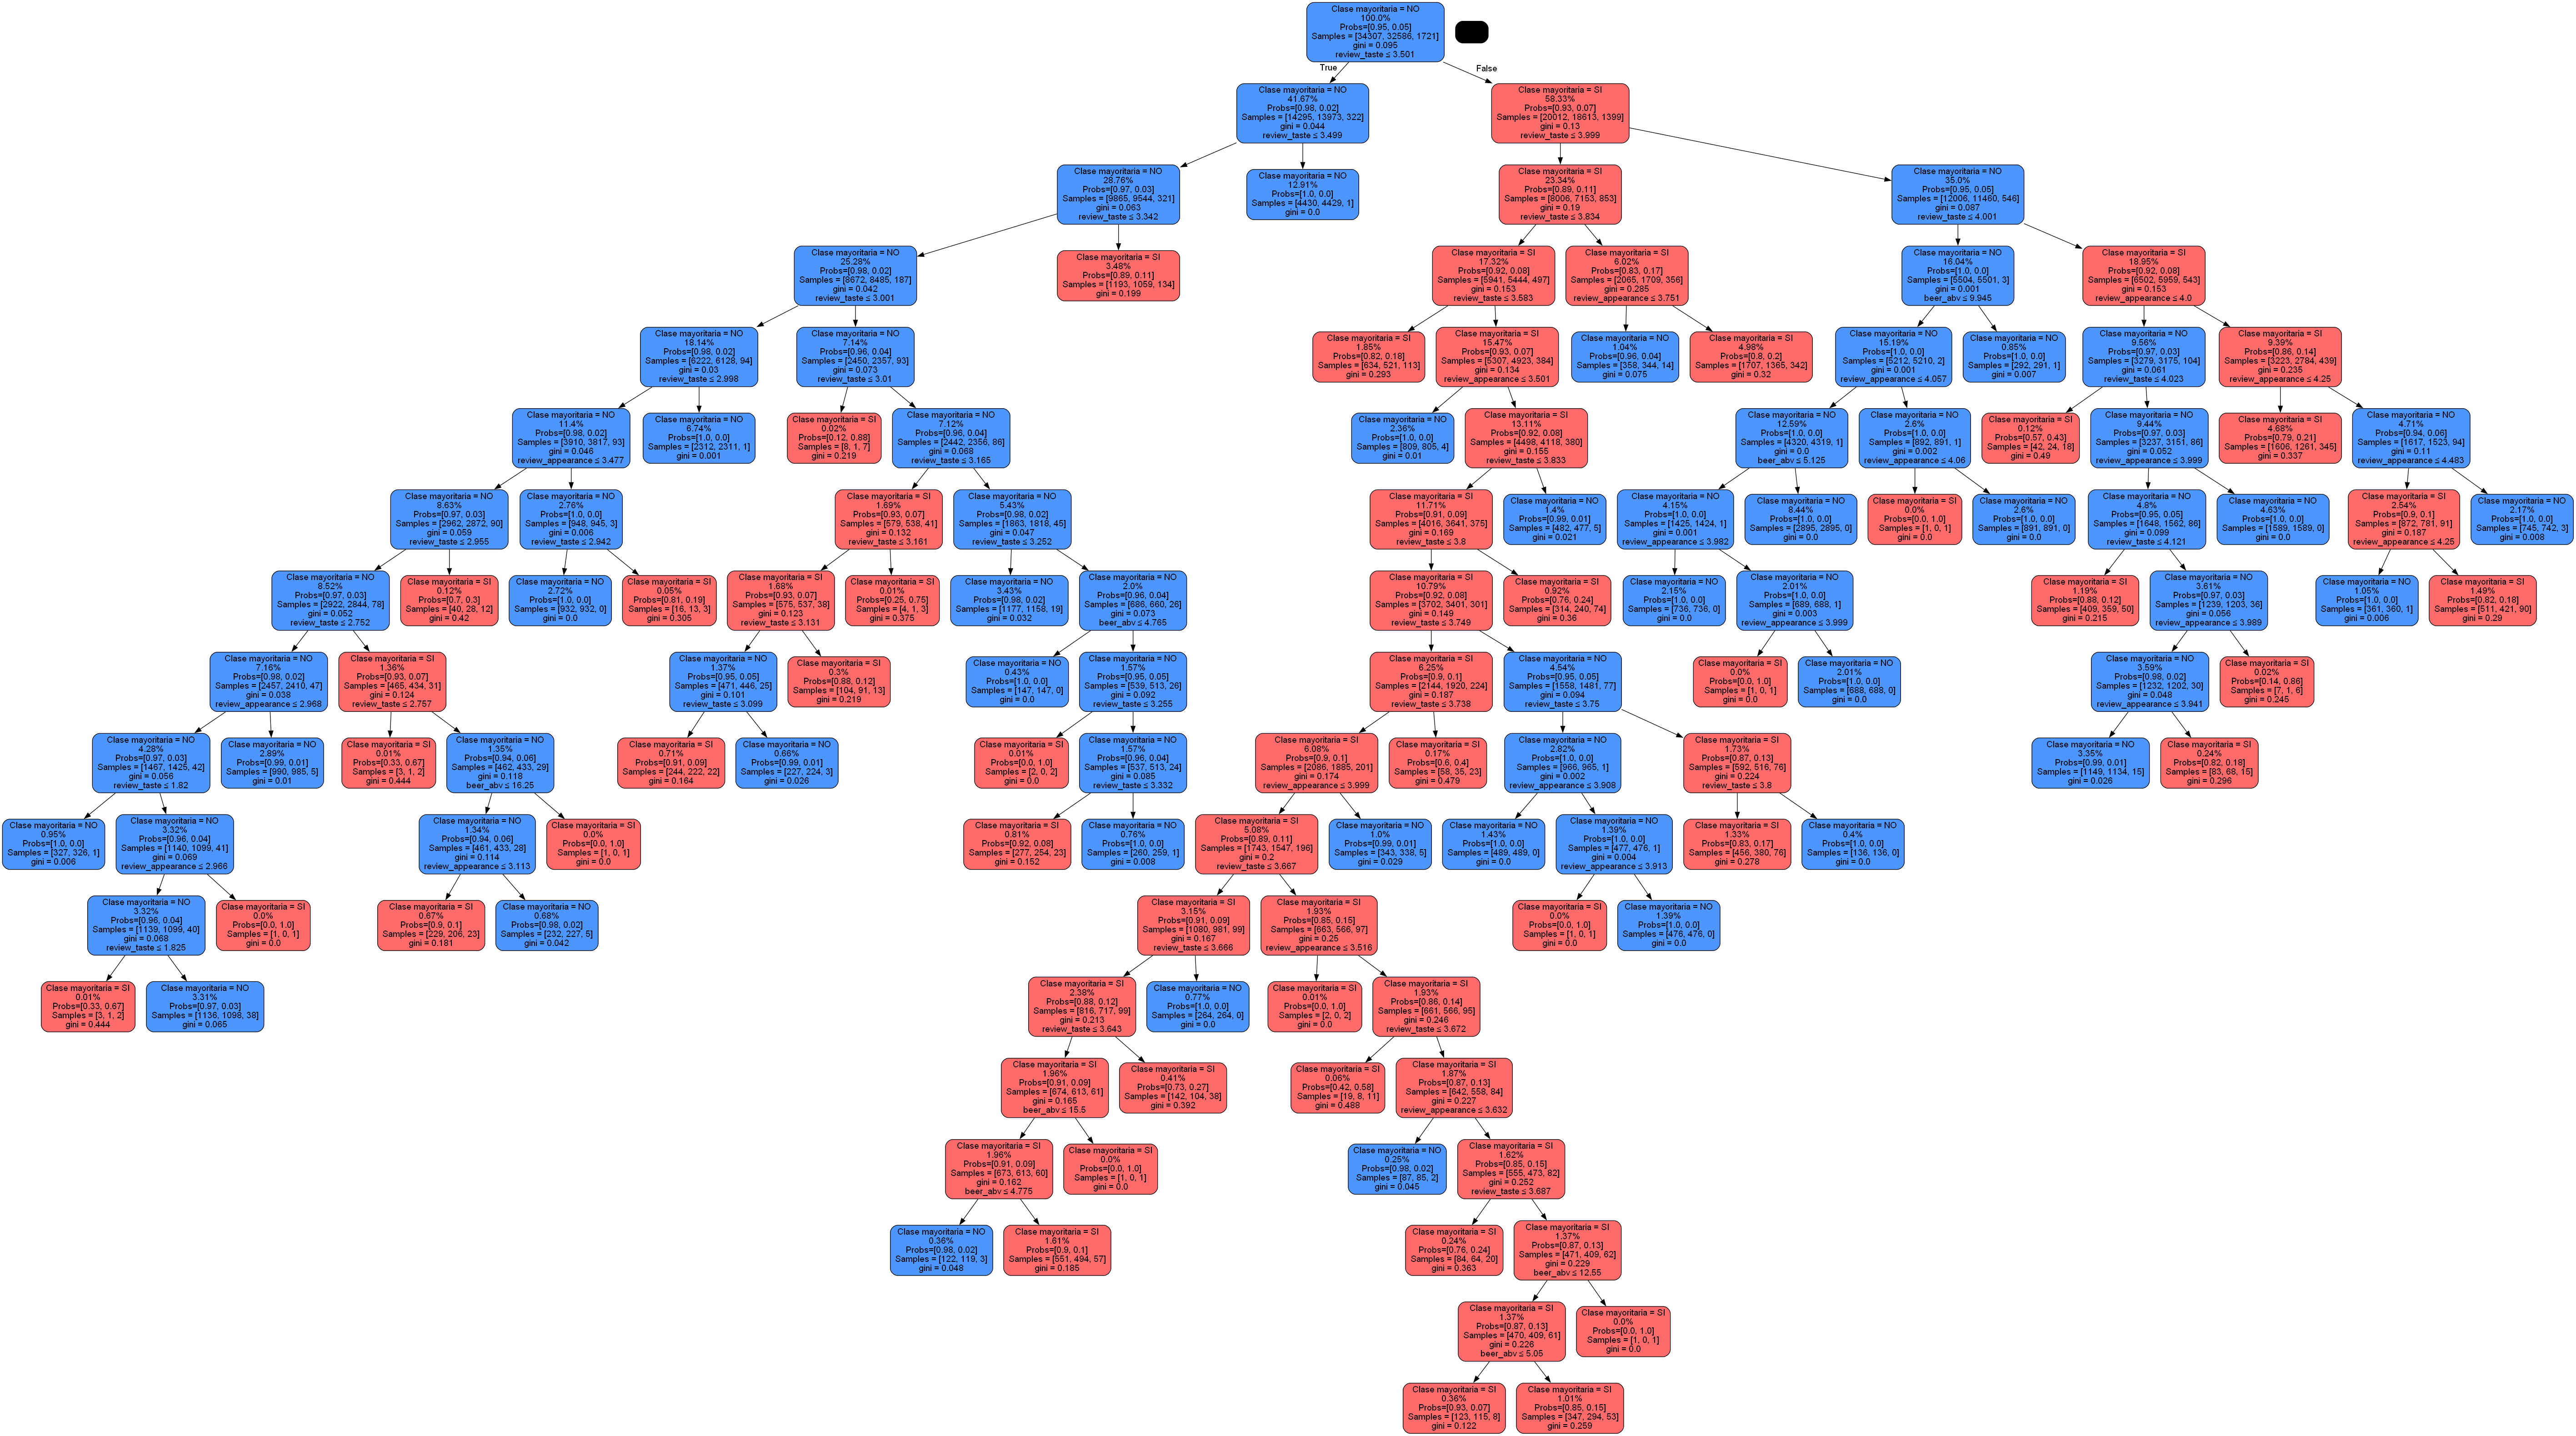

In [66]:
atu.prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"75,75"')
Image(graph.create_png())

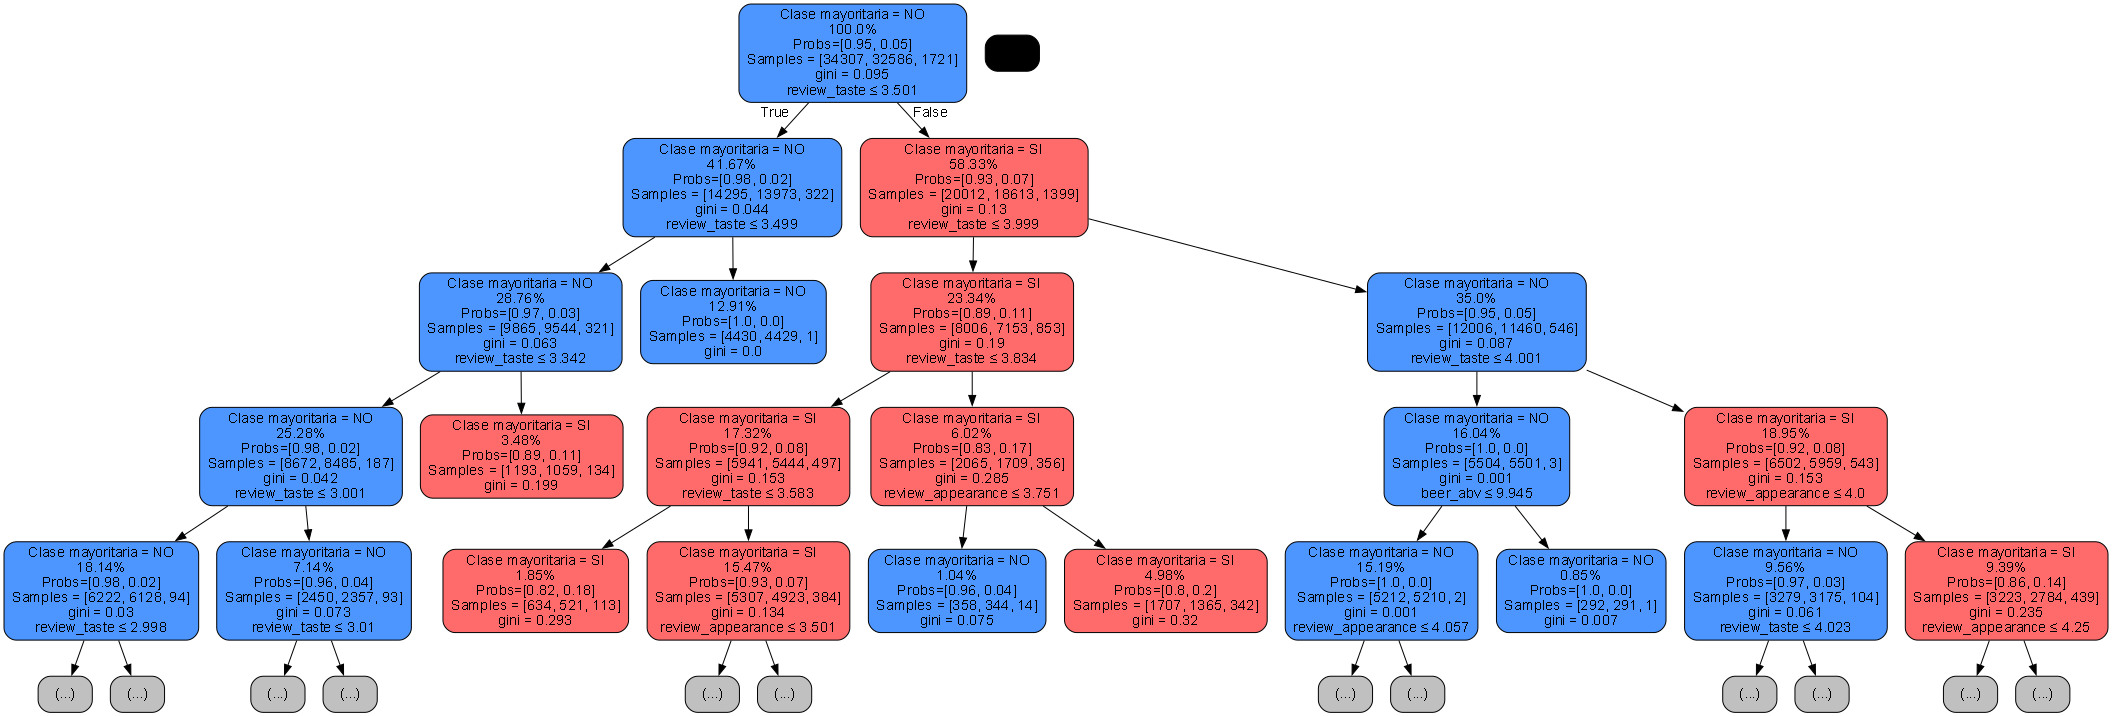

In [67]:
atu.prune_index(clf.tree_, 0, umbral_de_corte)

dot_data_value = agt.crear_arbol(clf, negative_class = 'NO', positive_class = 'SI', umbral = umbral_de_corte, max_depth=4)

graph = pydotplus.graph_from_dot_data(dot_data_value)  
graph.set_size('"22,22"')
Image(graph.create_png())

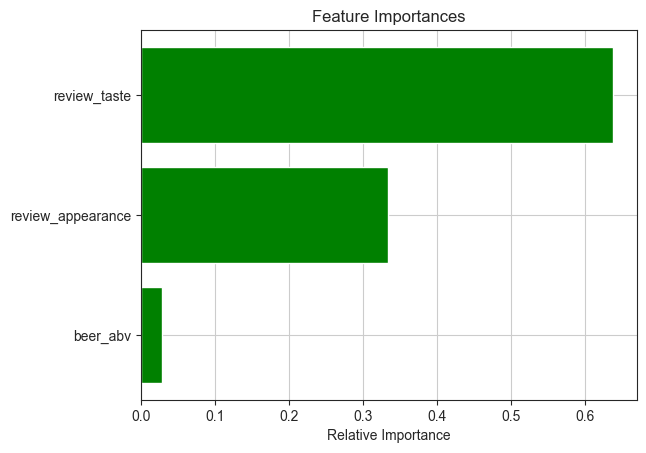

In [68]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = atributos
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Usamos SHAP values para explicar la importancia

In [69]:
import shap

In [70]:
y_training_pred = clf.predict_proba(df_training_validacion)
df_y_training_pred_proba = pd.DataFrame(y_training_pred, columns = ['NO_prob', 'SI_prob'])
y_training_pred = atu.evaluar_corte(df_y_training_pred_proba['NO_prob'].values, umbral_de_corte, 'SI', 'NO')

In [71]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(df_training_validacion)

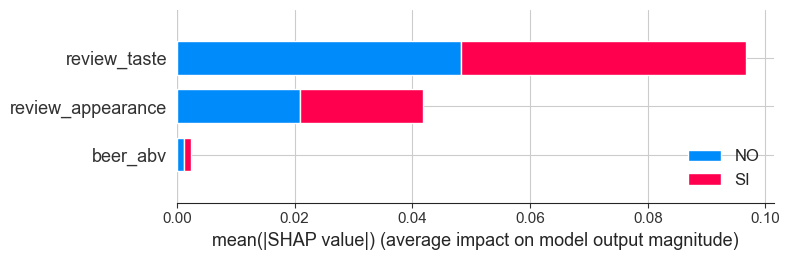

In [72]:
shap.summary_plot(shap_values, df_training_validacion.values, feature_names = atributos, class_names= ['NO','SI'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


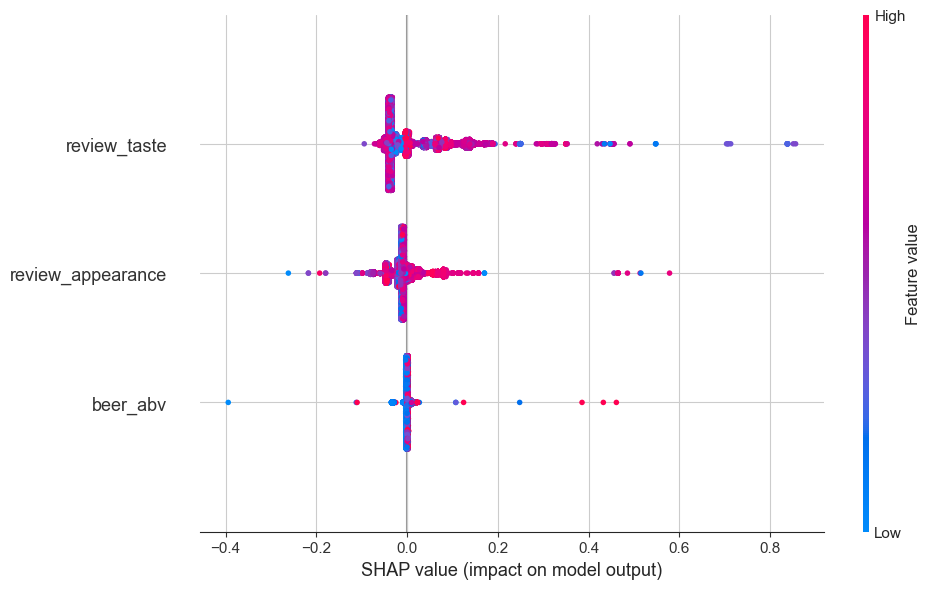

In [73]:
shap.summary_plot(shap_values[1], df_training_validacion.values, feature_names = atributos, plot_size=[10,6])

In [74]:
shap_df = pd.DataFrame(data = shap_values[1])
shap_df.columns = ['shap_' + sub for sub in atributos]
shap_df = pd.concat([shap_df, df_training_validacion, df_y_training_pred_proba, Y_df_training_validacion], axis=1)
shap_df['es_popular_prediccion'] = y_training_pred
shap_df

,shap_beer_abv,shap_review_appearance,shap_review_taste,beer_abv,review_appearance,review_taste,NO_prob,SI_prob,es_popular,es_popular_prediccion
0,0.006233,0.005962,0.041088,6.0,3.736000,3.592000,0.896552,0.103448,NO,SI
1,-0.001123,-0.019176,-0.024815,4.5,3.351351,2.743243,0.994949,0.005051,NO,NO
2,-0.001672,-0.007359,0.137099,4.4,3.727273,3.545455,0.821767,0.178233,NO,SI
3,0.000252,-0.012492,-0.032980,7.5,3.500000,3.750000,0.995056,0.004944,NO,NO
4,0.000252,-0.014149,-0.036042,7.8,3.500000,3.500000,0.999774,0.000226,NO,NO
...,...,...,...,...,...,...,...,...,...,...
34302,-0.001123,-0.013173,0.076454,4.5,3.400000,3.400000,0.887678,0.112322,NO,SI
34303,0.000252,-0.009851,-0.040133,5.8,4.000000,3.000000,0.999567,0.000433,NO,NO
34304,-0.001117,-0.009408,-0.039414,4.7,4.000000,3.500000,0.999774,0.000226,NO,NO
34305,0.000252,-0.009851,-0.024423,6.5,4.000000,3.166667,0.983857,0.016143,NO,NO


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


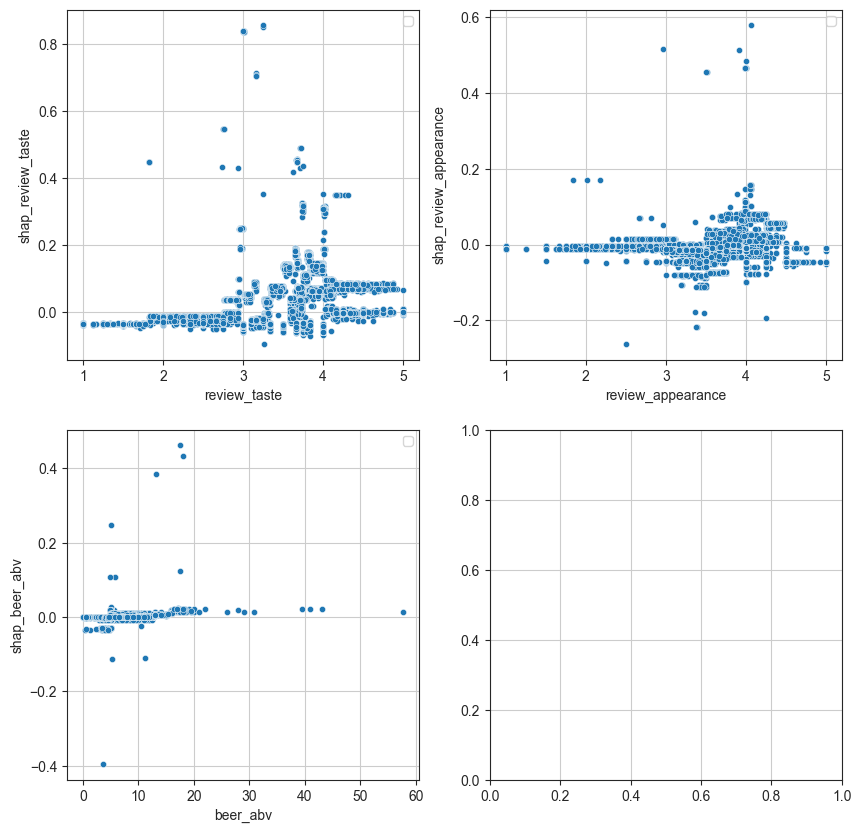

In [75]:
sns.set_style("ticks",{'axes.grid' : True})
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(10, 10))

atributos = [
    'beer_abv', 
    #'review_aroma', 
    'review_appearance', 
    'review_taste', 
    #'review_overall', 
    #'review_palate'
]

field = 'review_taste'
g1 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax1)
g1.legend(fontsize=9)

field = 'review_appearance'
g2 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax2)
g2.legend(fontsize=9)


field = 'beer_abv'
g3 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax3)
g3.legend(fontsize=9)


plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


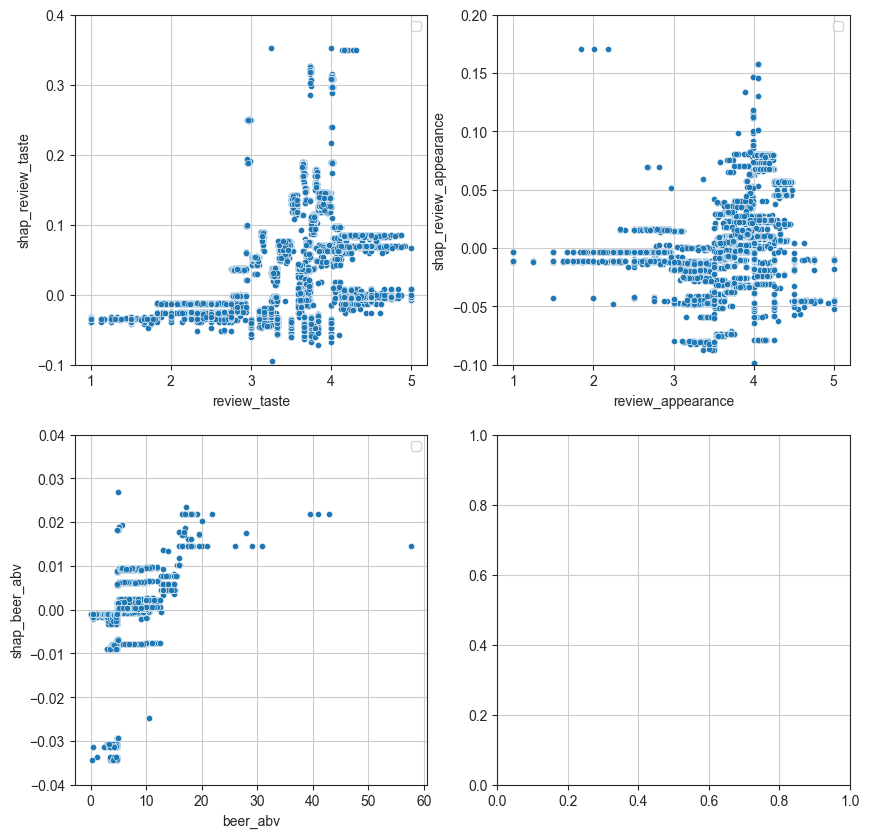

In [76]:
sns.set_style("ticks",{'axes.grid' : True})
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(10, 10))

field = 'review_taste'
ax1.set(ylim=(-0.1, 0.4))
g1 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax1)
g1.legend(fontsize=9)

field = 'review_appearance'
ax2.set(ylim=(-0.1, 0.2))
g2 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax2)
g2.legend(fontsize=9)


field = 'beer_abv'
ax3.set(ylim=(-0.04, 0.04))
g3 = sns.scatterplot(data=shap_df, x=field, y='shap_'+field, s=20, ax=ax3)
g3.legend(fontsize=9)


plt.show()

### Casos de cervezas NO populares

##############################################################################
beer_beerid                   76643
beer_name              Dunkle Punch
brewery_id                    16713
brewery_name                 HopCat
beer_style             Dunkelweizen
beer_abv                        5.8
review_overall                  4.0
review_aroma                    4.0
review_appearance               4.0
review_palate                   4.0
review_taste                    4.0
cantidad_revisiones               1
revision_primera         2011-12-24
revision_ultima          2011-12-24
es_popular                       NO
Name: 22845, dtype: object
##############################################################################
shap_beer_abv             0.000132
shap_review_appearance   -0.009975
shap_review_taste        -0.040322
beer_abv                       5.8
review_appearance              4.0
review_taste                   4.0
NO_prob                        1.0
SI_prob                       

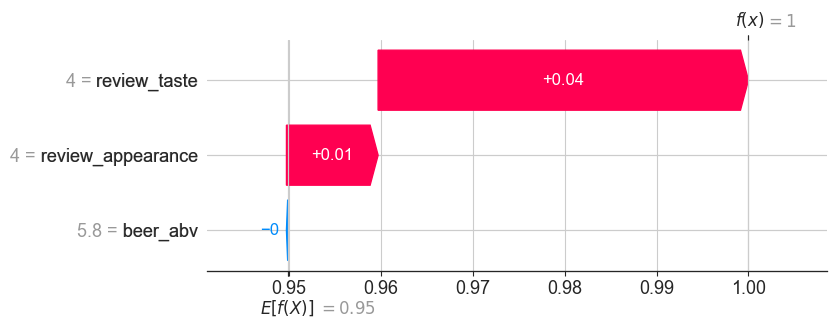

##############################################################################


##############################################################################
beer_beerid                      61198
beer_name                    Uavnieks
brewery_id                       15837
brewery_name                 Sia Zaksi
beer_style             German Pilsener
beer_abv                           4.2
review_overall                     3.5
review_aroma                       3.5
review_appearance                  3.5
review_palate                      3.5
review_taste                       3.5
cantidad_revisiones                  1
revision_primera            2010-08-20
revision_ultima             2010-08-20
es_popular                          NO
Name: 19619, dtype: object
##############################################################################
shap_beer_abv            -0.001117
shap_review_appearance   -0.013705
shap_review_taste        -0.035117
beer_abv                       4.2
review_ap

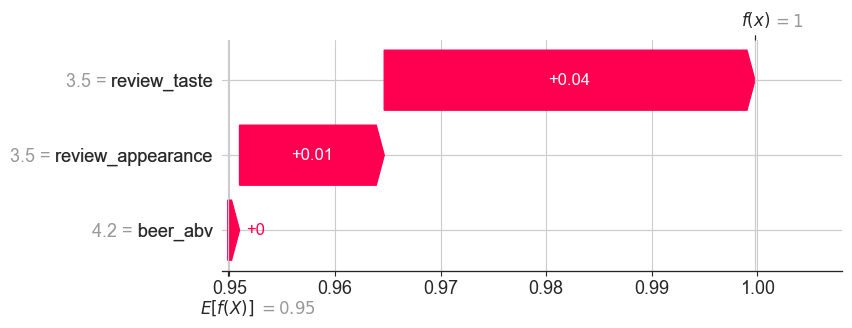

##############################################################################


##############################################################################
beer_beerid                                       65106
beer_name                               Gorgeous George
brewery_id                                         1550
brewery_name           Rock Bottom Restaurant & Brewery
beer_style                 English India Pale Ale (IPA)
beer_abv                                            6.7
review_overall                                      5.0
review_aroma                                        4.0
review_appearance                                   3.5
review_palate                                       4.0
review_taste                                        4.0
cantidad_revisiones                                   1
revision_primera                             2011-01-07
revision_ultima                              2011-01-07
es_popular                                           NO


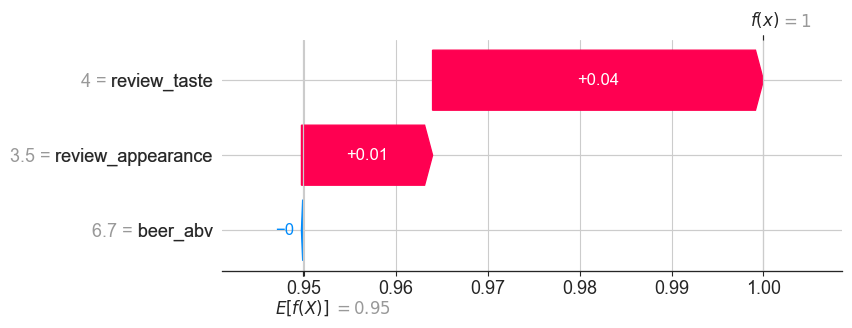

##############################################################################


##############################################################################
beer_beerid                             73846
beer_name                       Fumata Bianca
brewery_id                              13947
brewery_name           High & Mighty Beer Co.
beer_style                        Smoked Beer
beer_abv                                  4.2
review_overall                         3.5625
review_aroma                           3.8125
review_appearance                      3.9375
review_palate                          3.3125
review_taste                           3.6875
cantidad_revisiones                         8
revision_primera                   2011-10-06
revision_ultima                    2012-01-02
es_popular                                 NO
Name: 33186, dtype: object
##############################################################################
shap_beer_abv            -0.030644
shap_revi

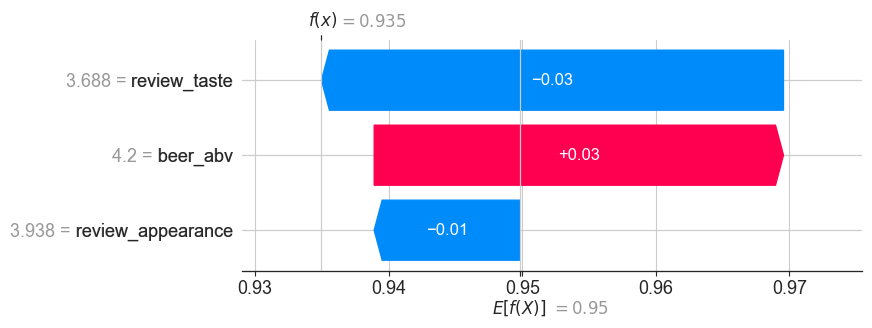

##############################################################################


##############################################################################
beer_beerid                                         65758
beer_name              Mesquite Aged Wet Willy Scotch Ale
brewery_id                                            357
brewery_name                      New England Brewing Co.
beer_style                         Scotch Ale / Wee Heavy
beer_abv                                             11.0
review_overall                                        4.0
review_aroma                                          4.0
review_appearance                                     5.0
review_palate                                         5.0
review_taste                                          4.0
cantidad_revisiones                                     1
revision_primera                               2011-01-30
revision_ultima                                2011-01-30
es_popular                  

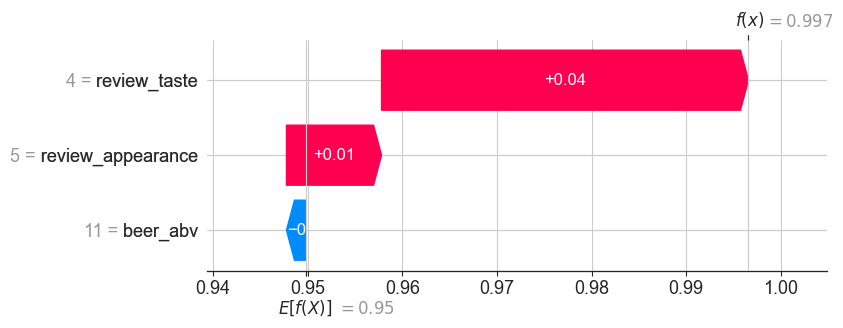

##############################################################################




In [77]:
rows = shap_df[
    (shap_df['es_popular'] == 'NO')
     &(shap_df['es_popular_prediccion'] == 'NO')
].sample(5).index

for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=df_training_validacion.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')

### Casos de cervezas populares

##############################################################################
beer_beerid                                 20524
beer_name                 Luciérnaga, The Firefly
brewery_id                                   9897
brewery_name           Jolly Pumpkin Artisan Ales
beer_style                       Belgian Pale Ale
beer_abv                                      6.5
review_overall                           4.040193
review_aroma                             4.117363
review_appearance                        4.220257
review_palate                            3.980707
review_taste                             4.065916
cantidad_revisiones                           311
revision_primera                       2004-10-28
revision_ultima                        2012-01-05
es_popular                                     SI
Name: 11257, dtype: object
##############################################################################
shap_beer_abv             0.000252
shap_review_appearance    0.06

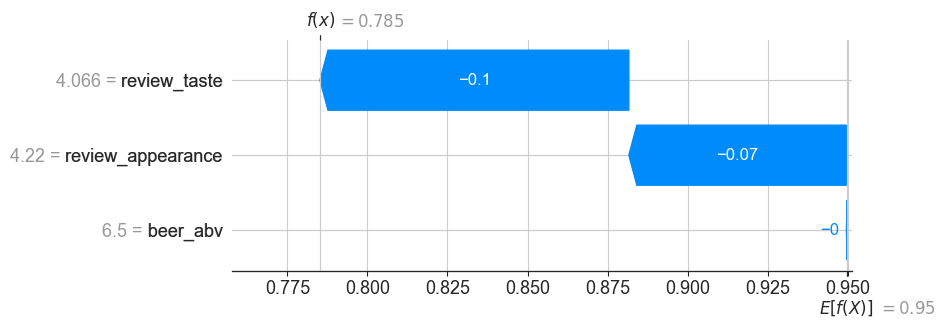

##############################################################################


##############################################################################
beer_beerid                              36692
beer_name                Honey Moon Summer Ale
brewery_id                                 306
brewery_name             Coors Brewing Company
beer_style             American Pale Wheat Ale
beer_abv                                   5.2
review_overall                        3.307278
review_aroma                          3.028302
review_appearance                     3.221024
review_palate                         3.152291
review_taste                          3.130728
cantidad_revisiones                        371
revision_primera                    2007-05-05
revision_ultima                     2011-11-09
es_popular                                  SI
Name: 18414, dtype: object
##############################################################################
shap_beer_abv             0.0

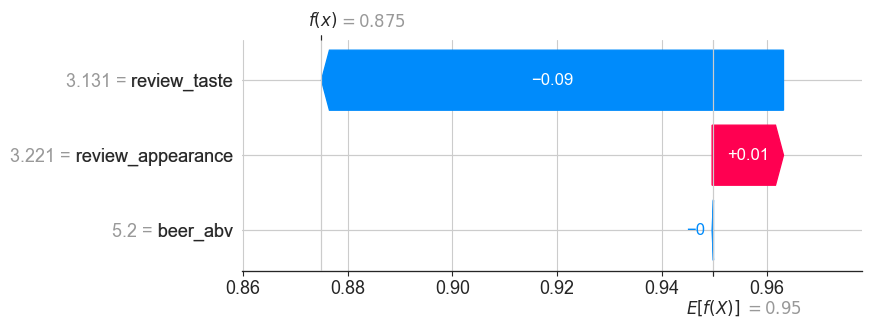

##############################################################################


##############################################################################
beer_beerid                                    47228
beer_name              Iniquity (Imperial Black Ale)
brewery_id                                      3818
brewery_name           Southern Tier Brewing Company
beer_style                        American Black Ale
beer_abv                                         9.0
review_overall                              4.029356
review_aroma                                4.015152
review_appearance                           4.101326
review_palate                               4.023674
review_taste                                 4.11553
cantidad_revisiones                              528
revision_primera                          2009-03-24
revision_ultima                           2012-01-10
es_popular                                        SI
Name: 7160, dtype: object
###################

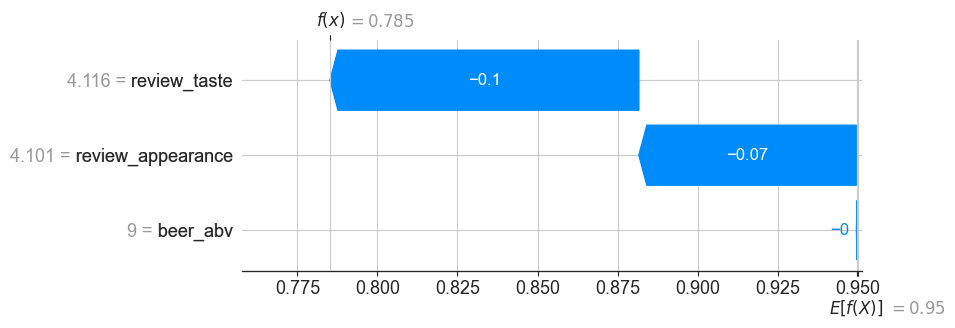

##############################################################################


##############################################################################
beer_beerid                         1137
beer_name              Brooklyner Weisse
brewery_id                            45
brewery_name            Brooklyn Brewery
beer_style                    Hefeweizen
beer_abv                             5.0
review_overall                  3.992453
review_aroma                    3.813208
review_appearance                3.69434
review_palate                   3.713208
review_taste                    3.803774
cantidad_revisiones                  265
revision_primera              2002-05-14
revision_ultima               2012-01-01
es_popular                            SI
Name: 28882, dtype: object
##############################################################################
shap_beer_abv            -0.000308
shap_review_appearance    0.010333
shap_review_taste         0.175479
beer_abv      

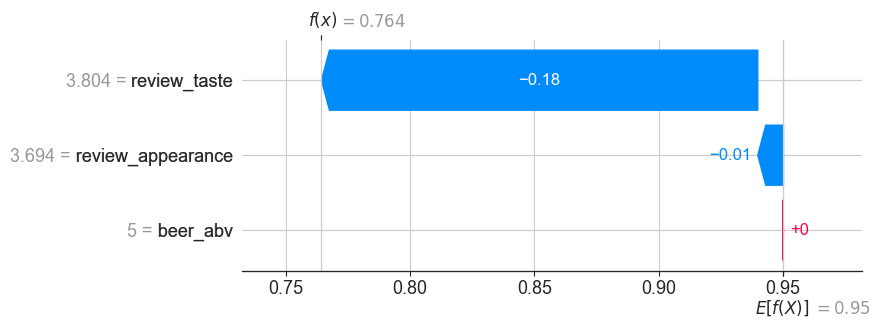

##############################################################################


##############################################################################
beer_beerid                                    817
beer_name                    De Dolle Stille Nacht
brewery_id                                     201
brewery_name           Brouwerij De Dolle Brouwers
beer_style                 Belgian Strong Pale Ale
beer_abv                                      12.0
review_overall                             3.86435
review_aroma                              4.127803
review_appearance                          3.96861
review_palate                             4.017937
review_taste                              4.150224
cantidad_revisiones                            446
revision_primera                        2001-03-25
revision_ultima                         2012-01-10
es_popular                                      SI
Name: 12361, dtype: object
################################################

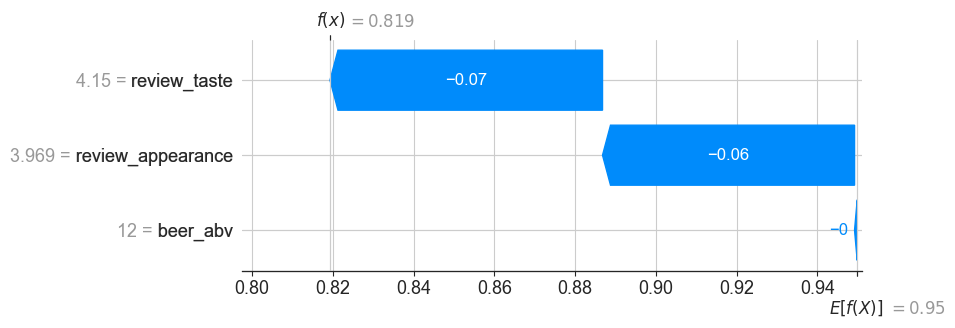

##############################################################################




In [78]:
rows = shap_df[
    (shap_df['es_popular'] == 'SI')
     &(shap_df['es_popular_prediccion'] == 'SI')
].sample(5).index

for row in rows:
    print('##############################################################################')
    print(df_info.iloc[row])
    print('##############################################################################')
    print(shap_df.iloc[row])
    explanation = shap.Explanation(
            values=shap_values[0][row], 
            base_values=explainer.expected_value[0], 
            data=df_training_validacion.iloc[row],
            feature_names=atributos
    )

    shap.waterfall_plot(explanation)
    print('##############################################################################\n\n')

### ¿Podemos sacar algún conocimiento extra?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


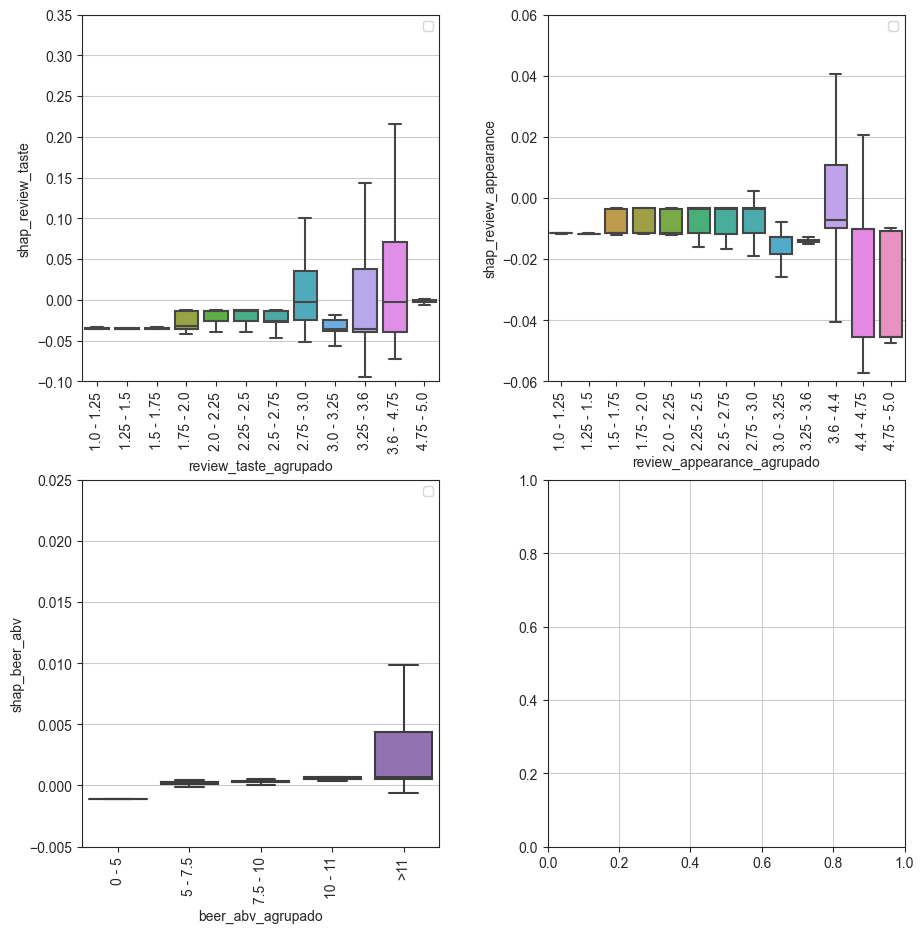

In [79]:
tmp = shap_df.copy()

conditions = [
    (tmp['review_taste'] >= 1) & (tmp['review_taste'] < 1.25),
    (tmp['review_taste'] >= 1.25) & (tmp['review_taste'] < 1.5),
    (tmp['review_taste'] >= 1.5) & (tmp['review_taste'] < 1.75),
    (tmp['review_taste'] >= 1.75) & (tmp['review_taste'] < 2),
    (tmp['review_taste'] >= 2) & (tmp['review_taste'] < 2.25),
    (tmp['review_taste'] >= 2.25) & (tmp['review_taste'] < 2.5),
    (tmp['review_taste'] >= 2.5) & (tmp['review_taste'] < 2.75),
    (tmp['review_taste'] >= 2.75) & (tmp['review_taste'] < 3),
    (tmp['review_taste'] >= 3) & (tmp['review_taste'] < 3.25),
    (tmp['review_taste'] >= 3.25) & (tmp['review_taste'] < 3.6),
    (tmp['review_taste'] >= 3.6) & (tmp['review_taste'] < 4.75),
    (tmp['review_taste'] >= 4.75) & (tmp['review_taste'] < 5)
]

values_taste = [
    '1.0 - 1.25', 
    '1.25 - 1.5', 
    '1.5 - 1.75', 
    '1.75 - 2.0', 
    '2.0 - 2.25', 
    '2.25 - 2.5', 
    '2.5 - 2.75', 
    '2.75 - 3.0', 
    '3.0 - 3.25', 
    '3.25 - 3.6',
    '3.6 -  4.75', 
    '4.75 - 5.0', 
    ]

tmp['review_taste_agrupado'] = np.select(conditions, values_taste)

conditions = [
    (tmp['review_appearance'] >= 1) & (tmp['review_appearance'] < 1.25),
    (tmp['review_appearance'] >= 1.25) & (tmp['review_appearance'] < 1.5),
    (tmp['review_appearance'] >= 1.5) & (tmp['review_appearance'] < 1.75),
    (tmp['review_appearance'] >= 1.75) & (tmp['review_appearance'] < 2),
    (tmp['review_appearance'] >= 2) & (tmp['review_appearance'] < 2.25),
    (tmp['review_appearance'] >= 2.25) & (tmp['review_appearance'] < 2.5),
    (tmp['review_appearance'] >= 2.5) & (tmp['review_appearance'] < 2.75),
    (tmp['review_appearance'] >= 2.75) & (tmp['review_appearance'] < 3),
    (tmp['review_appearance'] >= 3) & (tmp['review_appearance'] < 3.25),
    (tmp['review_appearance'] >= 3.25) & (tmp['review_appearance'] < 3.6),
    (tmp['review_appearance'] >= 3.6) & (tmp['review_appearance'] < 4.4),
    (tmp['review_appearance'] >= 4.4) & (tmp['review_appearance'] < 4.75),
    (tmp['review_appearance'] >= 4.75) & (tmp['review_appearance'] < 5)
]

values_appearance = [
    '1.0 - 1.25', 
    '1.25 - 1.5', 
    '1.5 - 1.75', 
    '1.75 - 2.0', 
    '2.0 - 2.25', 
    '2.25 - 2.5', 
    '2.5 - 2.75', 
    '2.75 - 3.0', 
    '3.0 - 3.25', 
    '3.25 - 3.6', 
    '3.6 - 4.4', 
    '4.4 - 4.75', 
    '4.75 - 5.0', 
    ]

tmp['review_appearance_agrupado'] = np.select(conditions, values_appearance)

conditions = [
    (tmp['beer_abv'] < 5),
    (tmp['beer_abv'] >= 5) & (tmp['beer_abv'] < 7.5),
    (tmp['beer_abv'] >= 7.5) & (tmp['beer_abv'] < 10),
    (tmp['beer_abv'] >= 10) & (tmp['beer_abv'] < 11),
    (tmp['beer_abv'] >= 11)
]

values_beer = [
    '0 - 5', 
    '5 - 7.5', 
    '7.5 - 10',
    '10 - 11', 
    '>11']

tmp['beer_abv_agrupado'] = np.select(conditions, values_beer)


sns.set_style("ticks",{'axes.grid' : True})
fig, ([[ax1, ax2], [ax3, ax4]]) = plt.subplots(2, 2, figsize=(10, 10))
fig.tight_layout(pad=5.0)

ax1.set(ylim=(-0.1, 0.35))
g1 = sns.boxplot(data=tmp, y="shap_review_taste", x="review_taste_agrupado", order=values_taste, orient = "v", ax=ax1, showfliers = False)
g1.legend(fontsize=9)
ax1.tick_params(axis='x', rotation=90)

ax2.set(ylim=(-0.06, 0.06))
g1 = sns.boxplot(data=tmp, y="shap_review_appearance", x="review_appearance_agrupado", order=values_appearance, orient = "v", ax=ax2, showfliers = False)
g1.legend(fontsize=9)
ax2.tick_params(axis='x', rotation=90)

ax3.set(ylim=(-0.005, 0.025))
g1 = sns.boxplot(data=tmp, y="shap_beer_abv", x="beer_abv_agrupado", order=values_beer, orient = "v", ax=ax3, showfliers = False)
g1.legend(fontsize=9)
ax3.tick_params(axis='x', rotation=90)
plt.show()


In [80]:
tmp = df_info.groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,32586,94.98
1,SI,1721,5.02


In [81]:
tmp = df_info[
    (df_info['review_taste'] >= 3.6)
    &(df_info['review_taste'] <= 4.75)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,17647,93.29
1,SI,1270,6.71


In [82]:
tmp = df_info[
    (df_info['review_appearance'] >= 3.6)
    & (df_info['review_appearance'] <=4.4)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,18606,92.92
1,SI,1417,7.08


In [83]:
tmp = df_info[
    (df_info['beer_abv'] >= 11)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,935,88.29
1,SI,124,11.71


In [84]:
tmp = df_info[
    (df_info['review_taste'] >= 3.6)
    &(df_info['review_taste'] <= 4.75)
    & (df_info['review_appearance'] >= 3.6)
    & (df_info['review_appearance'] <=4.4)
    & (df_info['beer_abv'] >= 11)
].groupby(by=['es_popular']).size().reset_index(name='counts')

aux = sum(tmp.counts)

tmp['%'] = round(tmp['counts']/aux*100, 2)

tmp

,es_popular,counts,%
0,NO,574,83.8
1,SI,111,16.2
